In [29]:
import os,sys,signal, copy
import math
from contextlib import contextmanager

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
import matplotlib.ticker as ticker
from matplotlib.animation import ArtistAnimation

from scipy.fftpack import fft
from scipy.signal.windows import hann

sys.path.insert(0, '../../')
import musicnetRaven as musicnet

from time import time

sys.path.insert(0,'../../lib/')
import config
import diagnosticsP3
# import base_model

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='3'

import torch
from torch.nn.functional import conv1d, mse_loss

from tqdm import tqdm
import mir_eval

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
# Network Parameters
epochs = 20
train_size = 100000
test_size = 50000
lr = 6e-7
pitch_shift = 0
jitter = 0.

# lvl1 convolutions are shared between regions
m = 128
k = 512              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 100

In [31]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [32]:
regions = 1 + (window - n_fft)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': 4, 'pin_memory': True, 'worker_init_fn': worker_init}

In [33]:
start = time()
root = '../../../data/'
train_set = musicnet.MusicNet(root=root, epoch_size=train_size
                              , train=True, download=True, refresh_cache=False, 
                              window=window, mmap=False, pitch_shift=pitch_shift, jitter=jitter)
test_set = musicnet.MusicNet(root=root, train=False, download=True, refresh_cache=False, window=window, epoch_size=test_size, mmap=False)
print("Time used = ", time()-start)

Time used =  20.482800006866455


In [34]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

In [35]:
def create_filtersv2(n_fft, freq_bins=None, low=50,high=6000, sr=44100, freq_scale='linear', mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = torch.arange(0, n_fft, 1.)
    wsin = torch.empty((freq_bins,1,n_fft))
    wcos = torch.empty((freq_bins,1,n_fft))
    start_freq = low
    end_freq = high
    

    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = 0.5-0.5*torch.cos(2*math.pi*s/(n_fft)) # same as hann(n_fft, sym=False)
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        
    if freq_scale == 'linear':
        start_bin = start_freq*n_fft/sr
        scaling_ind = (end_freq/start_freq)/freq_bins
        for k in range(freq_bins): # Only half of the bins contain useful info
            wsin[k,0,:] = window_mask*torch.sin(2*math.pi*(k*scaling_ind*start_bin)*s/n_fft)
            wcos[k,0,:] = window_mask*torch.cos(2*math.pi*(k*scaling_ind*start_bin)*s/n_fft)
    elif freq_scale == 'log':
        start_bin = start_freq*n_fft/sr
        scaling_ind = np.log(end_freq/start_freq)/freq_bins
        for k in range(freq_bins): # Only half of the bins contain useful info
            wsin[k,0,:] = window_mask*torch.sin(2*math.pi*(np.exp(k*scaling_ind)*start_bin)*s/n_fft)
            wcos[k,0,:] = window_mask*torch.cos(2*math.pi*(np.exp(k*scaling_ind)*start_bin)*s/n_fft)    
    else:
        print("Please select the correct frequency scale, 'linear' or 'log'")
    
    return wsin,wcos


In [36]:
Loss = torch.nn.MSELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [37]:
test = torch.randn((10,3)).to(device)

In [38]:
test

tensor([[-1.7569,  0.2037,  1.4625],
        [ 0.3148,  0.8127, -1.0121],
        [-1.3448,  0.3330, -0.3248],
        [ 0.6062, -0.9205, -0.7725],
        [-0.2886,  0.6352,  0.6579],
        [-0.4998,  0.0272, -0.6105],
        [-1.6132,  1.6478, -0.3132],
        [-0.2423, -0.9079, -0.1167],
        [-1.1634, -0.5678,  0.1436],
        [-1.9746,  1.8846, -0.3583]])

In [39]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()
        # Create filter windows
        wsin, wcos = create_filtersv2(n_fft,k, low=50, high=6000,
                                      mode="stft", freq_scale='log')

        self.wsin = torch.Tensor(wsin).to(device)
        self.wcos = torch.Tensor(wcos).to(device)

        # Creating Layers
#         self.linear = torch.nn.Linear(regions*k, k,bias=False)
#         self.linear_output = torch.nn.Linear(k,m, bias=False)
#         wscale = 10e-5
#         torch.nn.init.normal_(self.linear.weight, std=1e-4) # initialize
#         torch.nn.init.normal_(self.linear_output.weight, std=1e-4)
#         torch.nn.init.zeros_(self.linear.weight)
#         torch.nn.init.zeros_(self.linear_output.weight)
        self.k_out = 128
        self.Layer2 = torch.nn.Conv2d(1,self.k_out,
                                      kernel_size=(128,1),stride=(1,1))
        self.Layer3 = torch.nn.Conv2d(128,256,
                                      kernel_size=(1,25),stride=(1,1))

        self.Linear = torch.nn.Linear(self.k_out*385*regions, m)
        self.activation = torch.nn.ReLU()
        
        self.avg = avg
        #Create a container for weight average
        self.averages = copy.deepcopy(list(parm.to(device).data for parm in self.parameters())) 

        
    def forward(self,x):
        zx = conv1d(x[:,None,:], self.wsin, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos, stride=stride).pow(2)
        zx = torch.log(zx + 10e-8) # Log Magnitude Spectrogram
        z2 = self.Layer2(zx.unsqueeze(1)) # Make channel as 1 (N,C,H,W)
        y = self.Linear(self.activation(z2.view(x.data.size()[0],self.k_out*385*regions)))
        return y
    
    def average_iterates(self):
        for parm, pavg in zip(self.parameters(), self.averages):
            pavg.mul_(self.avg).add_(1.-self.avg, parm.data) # 0.9W_avg + 0.1W_this_ite
    
    
@contextmanager
def averages(model):
    orig_parms = copy.deepcopy(list(parm.data for parm in model.parameters()))
    for parm, pavg in zip(model.parameters(), model.averages):
        parm.data.copy_(pavg)
    yield
    for parm, orig in zip(model.parameters(), orig_parms):
        parm.data.copy_(orig)

# Averaged Weights

In [40]:
model = Model()
model.to(device)

Model(
  (Layer2): Conv2d(1, 128, kernel_size=(128, 1), stride=(1, 1))
  (Layer3): Conv2d(128, 256, kernel_size=(1, 25), stride=(1, 1))
  (Linear): Linear(in_features=1232000, out_features=128, bias=True)
  (activation): ReLU()
)

In [41]:
loss_history_train = []
avgp_history_train = []
loss_history_test = []
avgp_history_test = []
avg = .9998
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=.95)
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)

try:
    with train_set, test_set:
        total_i = len(train_loader)
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        for e in range(epochs):
            yground = torch.FloatTensor(batch_size*len(train_loader), m) # what not do this together with loss
            yhat = torch.FloatTensor(batch_size*len(train_loader), m)
            avgp, loss_e = 0.,0
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"Training {i}/{total_i} batches", end = '\r')
                optimizer.zero_grad()
#                 print(model.Layer2.weight[0][0][0])
                # making x and y into pytorch dealable format
                x = x.to(device,non_blocking=True)
                y = y.to(device,non_blocking=True)
                yhatvar = model(x)
                loss = L(yhatvar,y)
                loss.backward()
                loss_e += loss.item() #getting the number
                
                yground[i*batch_size:(i+1)*batch_size] = y.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
                
                optimizer.step()
                model.average_iterates() # Averaging the weights for validation
                
            avgp = average_precision_score(yground.flatten(),yhat.flatten())    
            loss_history_train.append(loss_e/len(train_loader))
            avgp_history_train.append(avgp)   
            t1 = time()
            avgp, loss_e = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight
            
            # For testing
            yground = torch.FloatTensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            
            for i, (x_test,y_test) in enumerate(test_loader):
                print(f"Testing {i}/{len(test_loader)} batches", end = '\r')
                x_test = x_test.cuda()
                y_test = y_test.cuda()
                yhatvar = model(x_test)
                loss_e += L(yhatvar, y_test).item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y_test.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())
            loss_history_test.append(loss_e/len(test_loader))
            avgp_history_test.append(avgp)
            print('{}\t{:2f}\t{:2f}\t{:2f}\t{:2f}\t{:2.1f}\t{:2.1f}'.\
                  format(e,
                         loss_history_train[-1],loss_history_test[-1],
                         avgp_history_train[-1],avgp_history_test[-1],
                         time()-t, time()-t1))


        
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")
    

epoch	train loss	test loss	train avg	test avg	time	utime
Graceful Exit000 batches


(0.3, 0.75)

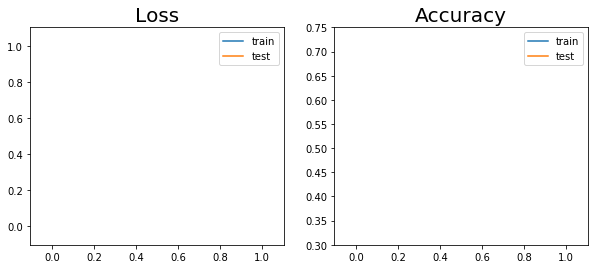

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(loss_history_train)
ax[0].plot(loss_history_test)
ax[0].legend(['train', 'test'])
ax[0].set_title('Loss', size=20)

ax[1].plot(avgp_history_train)
ax[1].plot(avgp_history_test)
ax[1].legend(['train', 'test'])
ax[1].set_title('Accuracy', size=20)
ax[1].set_ylim(0.3,0.75)

# Mirex stats

In [43]:
def get_mir_accuracy(Yhat, Y_true, threshold=0.4):
    Yhatlist = []
    Ylist = []
    Yhatpred = Yhat>threshold
    for i in range(len(Yhatpred)):
        print(f"{i}/{len(Yhatpred)} batches", end = '\r')
        fhat = []
        f = []
        for note in range(m):
            if Yhatpred[i][note] == 1:
                fhat.append(440.*2**(((note)-69.)/12.))

            if Y_true[i][note] == 1:
                f.append(440.*2**(((note)-69.)/12.))

        Yhatlist.append(np.array(fhat))
        Ylist.append(np.array(f))
    avp = average_precision_score(Y_true.flatten(),Yhat.detach().cpu().flatten())
    P,R,Acc,Esub,Emiss,Efa,Etot,cP,cR,cAcc,cEsub,cEmiss,cEfa,cEtot = \
    mir_eval.multipitch.metrics(np.arange(len(Ylist))/100.,Ylist,np.arange(len(Yhatlist))/100.,Yhatlist)
    print('{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}'.format(100*avp,100*P,100*R,Acc,Etot,Esub,Emiss,Efa))
    return avp,P,R,Acc,Etot
def get_piano_roll(rec_id, window=16384, stride=1000, offset=44100, count=7500):
    sf=4
    if stride == -1:
        stride = (test_set.records[rec_id][1] - offset - int(sf*window))/(count-1)
        stride = int(stride)
    else:
        count = (test_set.records[rec_id][1] - offset - int(sf*window))/stride + 1
        count = int(count)
        
    X = np.zeros([count, window])
    Y = np.zeros([count, m])    
        
    for i in range(count):
        X[i,:], Y[i] =  test_set.access(rec_id, offset+i*stride)
        
    batch_size = 500
    Y_pred = torch.zeros([count,m])
    for i in range(len(X)//500):
        X = torch.tensor(X[batch_size*i:batch_size*(i+1)]).float().cuda()    
        Y_pred[batch_size*i:batch_size*(i+1)] = model(X)
    
    return Y_pred, Y
    

In [44]:
plt.imshow(model.linear.weight.data.cpu(), aspect='auto')
plt.colorbar()

AttributeError: 'Model' object has no attribute 'linear'

In [ ]:
plt.imshow(model.linear_output.weight.data.cpu(), aspect='auto')
plt.colorbar()

In [ ]:
print('AvgP\tP\tR\tAcc\tETot\tESub\tEmiss\tEfa')
Accavg = 0
Etotavg = 0
for songid in test_set.rec_ids:
    Y_pred, Y_true = get_piano_roll(songid, stride=-1)
#     Yhatpred = Y_pred > 0.4
    _,_,_,Acc,Etot = get_mir_accuracy(Y_pred, Y_true)
    Accavg += Acc
    Etotavg += Etot

In [ ]:
print('Average Accuracy: \t{:2.2f}\nAverage Error: \t\t{:2.2f}'.format(Accavg*100/len(test_set.rec_ids), Etotavg*100/len(test_set.rec_ids)))

In [44]:
for songid in [1759]:
    model.eval()
    Y_pred, Y_true = get_piano_roll(songid, stride=-1)
#     Yhatpred = Y_pred > 0.4
    _,_,_,Acc,Etot = get_mir_accuracy(Y_pred, Y_true)

torch.Size([16384])


IndexError: too many indices for tensor of dimension 1

In [30]:
from pypianoroll import Multitrack, Track, load, parse

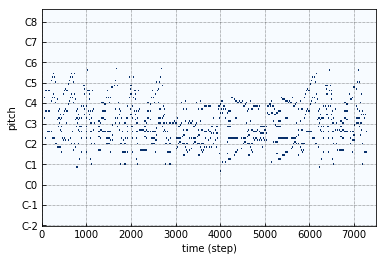

In [83]:
# Create a piano-roll matrix, where the first and second axes represent time
# and pitch, respectively, and assign a C major chord to the piano-roll
# Create a `pypianoroll.Track` instance
track = Track(pianoroll=Y_true*127, program=0, is_drum=False,
              name='my awesome piano')

# Plot the piano-roll
fig, ax = track.plot()

In [87]:
Yhatpred = Y_pred > 0.4

In [88]:
Yhatpred = Yhatpred.cpu().numpy()

In [93]:
def export_midi(Y_pred, path):
    # Create a piano-roll matrix, where the first and second axes represent time
    # and pitch, respectively, and assign a C major chord to the piano-roll
    # Create a `pypianoroll.Track` instance
    track = Track(pianoroll=Y_pred*127, program=0, is_drum=False,
                  name='my awesome piano')   
    multitrack = Multitrack(tracks=[track], tempo=120.0, beat_resolution=24)
    multitrack.write(path)

In [96]:
export_midi(Y_true, './Y_true.mid')

In [58]:
torch.save(model.state_dict(), './weights/1 Layer CNN')

In [102]:
torch.save(model, './weights/Toy_model_full')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
